Install + Imports

In [ ]:
!pip install seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

Load Dataset

In [ ]:
df = pd.read_csv('/content/ecommerce_rfm_data.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,Country
0,10102,2023-01-05,270456,9,35.274140,USA
1,10435,2023-01-02,219585,2,43.938992,Germany
2,10348,2023-01-22,217272,7,65.237321,UK
3,10270,2023-04-22,226619,5,7.290625,USA
4,10106,2023-02-26,275069,3,90.287540,France


Clean + Add TotalAmount

In [ ]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

RFM Calculation

In [ ]:
ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

Score RFM

In [ ]:
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

Define Segments

In [ ]:
def segment_customer(row):
    score = row['RFM_Score']
    if score == '555':
        return 'Champion'
    elif row['R'] >= 4:
        return 'Loyal'
    elif row['F'] == 5:
        return 'Frequent Buyer'
    elif row['R'] <= 2:
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
0,10000,11,11,3764.395964,5,4,5,545,Loyal
1,10001,26,7,2021.522949,4,2,3,423,Loyal
2,10002,49,9,1245.299235,2,3,1,231,At Risk
3,10003,2,9,2078.881238,5,3,3,533,Loyal
4,10004,25,12,3617.649036,4,5,5,455,Loyal


Visualize Segments

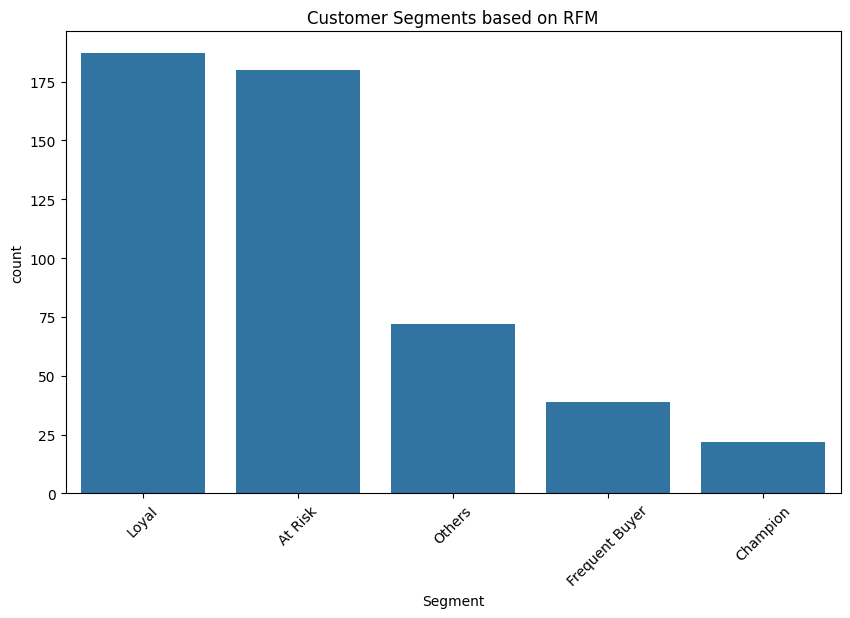

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title("Customer Segments based on RFM")
plt.xticks(rotation=45)
plt.show()

export

In [ ]:
rfm.to_csv("RFM_Customer_Segments.csv", index=False)